# Environment preparation - fetching dataset and library import

In [0]:
from google.colab import drive
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from scipy import misc

In [0]:
drive.mount('/content/drive/')

In [0]:
! date && unzip -q /content/drive/'My Drive'/celeb_dataset.zip -d /content/  && date

Wed Nov 21 18:11:43 UTC 2018
unzip:  cannot find or open /content/drive/My Drive/celeb_dataset.zip, /content/drive/My Drive/celeb_dataset.zip.zip or /content/drive/My Drive/celeb_dataset.zip.ZIP.


In [0]:
#create a directory for preprocessed TFRecord files
!ls /content/
!mkdir /content/preprocessed/
!ls /content/

In [0]:
def peek_file(file_path, n_lines):
  """
  helper function to peek first n_lines of the file
  """
  try:
    n_lines = int(n_lines)
    assert(n_lines > 0)
  except ValueError:
    print("Number of lines argument must be integer-interpretable")
  except AssertionError:
    print("Number of lines must be positive")
    
  with open(file_path) as file:
    for line in range(n_lines):
      print(file.readline(), end="")
  return



# Settings

In [0]:
# path to downloaded dataset (unzipped)
DOWNLOADED_PATH = '/content/celeb' #@param {type:"string"}

# path to preprocessed dataset (tf records)
SAVED_DATASET = '/content/preprocessed/' #@param {type:"string"}

TRAIN_FILENAME = 'train.tfrecords' #@param {type:"string"}
VAL_FILENAME = 'val.tfrecords' #@param {type:"string"}
TEST_FILENAME = 'test.tfrecords' #@param {type:"string"}


# tensorflow tf records dataset settings
DECODE_PARALLEL_CALLS = 103 #@param {type:"slider", min:20, max:400, step:1}
SHUFFLE_BUFFER_SIZE = 100 #@param {type:"slider", min:20, max:400, step:1}
PREFETCH_BUFFER_SIZE = 100 #@param {type:"slider", min:20, max:400, step:1}

BATCH_SIZE = 37 #@param {type:"slider", min:1, max:1000, step:1}




In [0]:
ANNO_PATH = os.path.join(DOWNLOADED_PATH, 'Anno',  'list_attr_celeba.txt') #file that indicates to which classes an image belongs to 
IMG_PATH = os.path.join(DOWNLOADED_PATH, 'Img') #path to images directory
EVAL_PATH = os.path.join(DOWNLOADED_PATH, 'Eval', 'list_eval_partition.txt') #file that indicates how to split the dataset into training, validation and testing sets


# Decoding TFRecords

In [0]:
def dataset_wrapper(session, dataset):
    """
    Wraps TensorFlow dataset into generator.
    :param session:
    :param dataset: tf.data.Dataset object
    """
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    while True:
        try:
            data = session.run(next_element)
            yield data
        except tf.errors.OutOfRangeError:
            break
            
def _decode_record(record):
    """
    Decodes record from bytes to arrays.
    """
    features_dict = {
        'image': tf.FixedLenFeature((), tf.string),
        'tags': tf.FixedLenFeature((), tf.string),
    }

    features = tf.parse_single_example(record, features=features_dict)
    #data had been written as uint8 to save up space...
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, shape=(218, 178, 3))
    #.. but we need more precison on calculation
    image = tf.cast(image, tf.float32)
    image = image / 255.0 #normalize
    tags = tf.decode_raw(features['tags'], tf.uint8)

    return {
        'image': image,
        'tags': tags
    }

In [0]:
# TASK 3
#21:50 20.11.2018 Done
def make_dataset(dataset_path, batch_size=128, shuffle=False, epochs=1, count_limit=10):
  dataset = tf.data.TFRecordDataset(dataset_path)
  dataset = dataset.map(_decode_record)
  if(shuffle):
    dataset = dataset.shuffle(epochs)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(count_limit)
  return dataset
  raise NotImplementedError
  
  """
  Creates dataset pipeline. Use https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset
  :param count_limit:
  :return: tf.data.TFRecordDataset object
  """

# Writting to TFRecords

In [0]:
peek_file(EVAL_PATH, 20)

In [0]:
#TASK 1
#19:30 20.11.2018 Done

def _load_splits():
	    dictionary = {}
	    with open(EVAL_PATH) as f:
	      for line in f:
	         (key, val) = line.split()
	         if val in dictionary:
	          # append the new number to the existing array at this slot
	            dictionary[val].append(key)
	         else:
	            # create a new array in this slot
	            dictionary[val] = [key]
	    return dictionary
	    raise NotImplementedError
_load_splits()

In [0]:
peek_file(ANNO_PATH, 20)

202599
5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young 
000001.jpg -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1
000002.jpg -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
000003.jpg -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1
000004.jpg -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1  1
0000

In [0]:
#TASK 2
#20:50 20.11.2018 Done

def _load_tags():
    dictionary = {}
    lines = [line.rstrip('\n') for line in open(ANNO_PATH)]
    #number of images = 202599
    for i in range(2, len(lines)):
      file_name = lines[i].split()[0]
      line_length = len(lines[i].split())
      tags_array = []
      for k in range(1, line_length):
        if(int(lines[i].split()[k]) > 0):
          tags_array.append(1)
        else:
          tags_array.append(0)
      dictionary[file_name] = np.array(tags_array)
    return dictionary
    raise NotImplementedError
    
_load_tags()

In [0]:
def _bytes_feature(value):
    """
    Helper function for feature encoding.
    :param value:
    :return:
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _write_records(dataset_filename, image_filename_iterator, tags):
    """
    Writes images and tags to file.
    :param dataset_filename:
    :param image_filename_iterator: iterable containing filenames
    :param tags: dictionary containing pairs filename: tags
    :return:
    """
    with tf.python_io.TFRecordWriter(dataset_filename) as writer:
        for image_filename in tqdm(iterable=image_filename_iterator,
                                   desc='writting {} dataset'.format(dataset_filename)):
            tag = tags[image_filename]
            image = misc.imread(os.path.join(IMG_PATH, image_filename.replace('.jpg', '.png')))

            # store as uint8
            image = image.astype(np.uint8)
            feature = {
                'image': _bytes_feature([image.tostring()]),
                'tags': _bytes_feature([tag.tostring()]),
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
    sys.stdout.flush()

In [0]:
def _create_dataset(train_filename, val_filename, test_filename):
    """
    Creates dataset in target location.
    To be implemented by students
    :param train_filename:
    :param val_filename:
    :param test_filename:
    """
    splits = _load_splits()
    tags = _load_tags()

    _write_records(train_filename, splits['0'], tags)
    _write_records(val_filename, splits['1'], tags)
    _write_records(test_filename, splits['2'], tags)

In [0]:
def maybe_create_dataset():
    """
    Function creates TensorFlow dataset if it does not exist.
    :return: (train_filename, val_filename, test_filename)
    """
    train_filename = os.path.join(SAVED_DATASET, TRAIN_FILENAME)
    val_filename = os.path.join(SAVED_DATASET, VAL_FILENAME)
    test_filename = os.path.join(SAVED_DATASET, TEST_FILENAME)

    if not all([os.path.exists(filename)
                for filename
                in [train_filename, val_filename, test_filename]]):
        _create_dataset(train_filename, val_filename, test_filename)
    return train_filename, val_filename, test_filename

#Main pipeline

In [0]:
train_filename, val_filename, test_filename = maybe_create_dataset()

In [0]:
with tf.Session() as session:
    train_set = make_dataset(
        dataset_path=train_filename,
        batch_size=512,
        shuffle=True,
        epochs=2000,
        count_limit=10,
    )

0it [00:00, ?it/s]

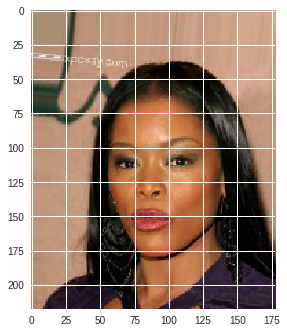


0it [00:00, ?it/s]

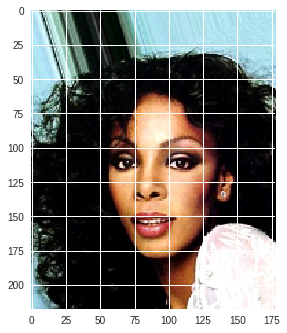


0it [00:00, ?it/s]

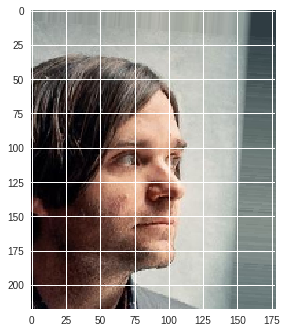


0it [00:00, ?it/s]

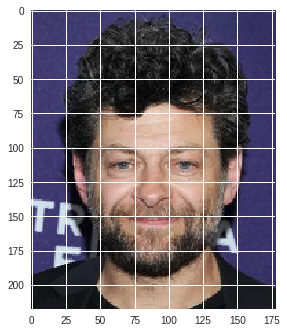

In [0]:
with tf.Session() as session:    
#     for data in tqdm(dataset_wrapper(session, train_set)):
#         break
        

#     for data in tqdm(dataset_wrapper(session, train_set)):
#         plt.imshow(data['image'][0])
#         plt.show()
#         break
  number_of_photos_to_show=5
  for iterations in range(1,number_of_photos_to_show):
    for data in tqdm(dataset_wrapper(session, train_set)):
      plt.imshow(data['image'][0])
      plt.show()
      break